In [1]:
# load ndjson file
import ndjson
import pandas as pd
from rdflib import Graph, Literal, Namespace
from rdflib.namespace import OWL, SKOS
import unicodedata
import matplotlib.pyplot as plt
import datetime

In [2]:
# load current YSA
ysa = Graph()
ysa.parse('http://finto.fi/rest/v1/ysa/data?format=text/turtle')
print('Number of triples in YSA: ', len(ysa))

# load current Allärs
allars = Graph()
allars.parse('http://finto.fi/rest/v1/allars/data?format=text/turtle')
print('Number of triples in Allärs: ', len(allars))

# load YSO and YSO Places
yso = Graph()
yso.parse("../git/Annif-corpora/vocab/yso-skos.ttl", format='turtle')
print('Number of triples in YSO+YSO Places: ', len(yso))

Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#date, Converter=<function parse_date at 0x7f7e83dc0940>
Traceback (most recent call last):
  File "/home/local/jmminkin/experiments/repository-metrics-analysis/venv/lib/python3.8/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/home/local/jmminkin/experiments/repository-metrics-analysis/venv/lib/python3.8/site-packages/isodate/isodates.py", line 201, in parse_date
    return date(sign * int(groups['year']),
ValueError: month must be in 1..12


Number of triples in YSA:  433048
Number of triples in Allärs:  412097
Number of triples in YSO+YSO Places:  830887


In [3]:
YSO = Namespace('http://www.yso.fi/onto/yso/')
COMPLAIN = False  # whether to complain about unknown labels


def is_deprecated(ysouri):
    return (ysouri, OWL.deprecated, True) in yso


def label_to_yso_uris(label, voc, lang, complain=COMPLAIN):
    # based on https://github.com/NatLibFi/Annif-corpora/blob/6521d0357f3d93019f6d2838b960e80d9131735c/tools/finna-metadata-collect-scripts/create-corpus.py#L54
    
    # Remove trailing "." present in labels of some records
    try:
        value = Literal(unicodedata.normalize('NFC', label.rstrip('.')), lang)
    except Exception as e:
        print("Error normalizing label '{}'".format(label))
        return []

    for prop in (SKOS.prefLabel, SKOS.altLabel):
        vocuri = voc.value(None, prop, value, any=True)
        if vocuri is not None:
            if vocuri.startswith(YSO):
                return [vocuri]
            for matchprop in (SKOS.exactMatch, SKOS.closeMatch):
                matches = [match for match in voc.objects(vocuri, matchprop)
                           if match.startswith(YSO)]
                if matches:
                    return matches

    # hackish fallbacks for cases like "kulttuuri", where YSO Cicero is out of
    # date: look up via ysa/allars
    if lang == 'fi' and voc == yso:
        matches = label_to_yso_uris(label, ysa, lang)
        if matches:
            print("missing fi label '{}' found via ysa".format(label))
            return matches

    if lang == 'sv' and voc == yso:
        matches = label_to_yso_uris(label, allars, lang)
        if matches:
            print("missing sv label '{}' found via allars".format(label))
            return matches

    if complain:
        print("Unknown label '{}'".format(label))
    return []

In [4]:
def add_subjects_uris(df, lang, source_col):
    df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
    df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])
    return df


def calc_scores(df):
    # calculate precision, recall, f1
    df["precision"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.suggestions) if len(x.suggestions) > 0 else pd.np.nan, axis=1)
    df["recall"] = df.apply(lambda x: len(set(x.subjects_uris) & set(x.suggestions)) / len(x.subjects_uris) if len(x.subjects_uris) > 0 else pd.np.nan, axis=1)
    df["f1 score"] = df.apply(lambda x: 2 * x.precision * x.recall / (x.precision + x.recall) if (x.precision + x.recall) != 0 else 0, axis=1)
    df['f1 score'] = pd.to_numeric(df['f1 score'])


def plot_scores(df, date_col, groupby='M'):
    calc_scores(df)
    # plot precision, recall, f1 as a function of date_col grouped by groupby
    df = df.set_index(date_col)
    df.resample(groupby).mean().plot(marker='o')
    plt.grid()
    plt.title(f"Precision, recall, f1 scores by {date_col} grouped by {groupby}")


def get_number_of_rows(df):
    print("rows: ", len(df))
    print("rows with subjects_yso: ", len(df[df.subjects_yso.apply(lambda x: len(x) > 0)]))
    print("rows with subjects_all: ", len(df[df.subjects_all.apply(lambda x: len(x) > 0)]))
    print("rows with suggestions: ", len(df[df.suggestions.apply(lambda x: len(x) > 0)]))
    print("rows with subjects_uris: ", len(df[df.subjects_uris.apply(lambda x: len(x) > 0)]))
    print("rows with both suggestions & subject_uris: ", len(retain_relevant(df)))
    # print("rows with both suggestions & subject_uris: ", len(df[df.suggestions.apply(lambda x: len(x) > 0) & df.subjects_uris.apply(lambda x: len(x) > 0)]))
    # print("rows without subjects_uris: ", len(df[df.subjects_uris.apply(lambda x: len(x) == 0)]))
    # print("rows without suggestions: ", len(df[df.suggestions.apply(lambda x: len(x)
    # == 0)]))


def retain_relevant(df):
    df = df.copy()
    return df[df.suggestions.apply(lambda x: len([e for e in x if e != '']) > 0) & df.subjects_uris.apply(lambda x: len([e for e in x if e != '']) > 0)]


# Months when Annif models were updated
annif_updates = [
    "2020-12",
    "2021-04",
    "2021-11",
    "2022-06",
    "2022-11",
]
# convert to datetime with utc timezone
annif_updates = [datetime.datetime.strptime(x, "%Y-%m").replace(tzinfo=datetime.timezone.utc) for x in annif_updates]

def get_annif_update(date):
    return max([upd for upd in annif_updates if upd<date], default=None)


# Osuva
Annif integration to use in Osuva in 11.3.2020

In [5]:
with open("osuva.ndjson") as f:
    data = ndjson.load(f)
df = pd.DataFrame(data)

df.date_issued = pd.to_datetime(df.date_issued, errors='coerce', utc=True)
df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='coerce', utc=True)
df['annif_update'] = df.date_accessioned.map(get_annif_update)

print(len(df))
print(len(df[df.language == 'fin']))
print(len(df[df.language == 'eng']))
print(len(df[df.language == 'swe']))

12699
6103
4783
303


In [6]:
df_fi = df[df.language == 'fin']
df_fi = add_subjects_uris(df_fi, 'fi', source_col='subjects_all')
get_number_of_rows(df_fi)
# Retain only rows having both suggestions and subjects_uris
df_fi = retain_relevant(df_fi)

missing fi label 'arvot' found via ysa
missing fi label 'sijoitukset' found via ysa
missing fi label 'arvo' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'sijoitukset' found via ysa
missing fi label 'sijoitukset' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'maidontuotanto' found via ysa
missing fi label 'arvo' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'sijoitukset' found via ysa
missing fi label 'ekosysteemit' found via ysa
missing fi label 'kuormat' found via ysa
missing fi label 'pääkaupunkiseutu' found via ysa
missing fi label 'arvo' found via ysa
missing fi label 'sijoitukset' found via ysa
missing fi label 'kilpailukiellot' found via ysa
missing fi label 'hybridit' found via ysa
missing fi label 'arvot' found via

/tmp/ipykernel_725030/839729998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_725030/839729998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


/tmp/ipykernel_725030/839729998.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.resample(groupby).mean().plot(marker='o')


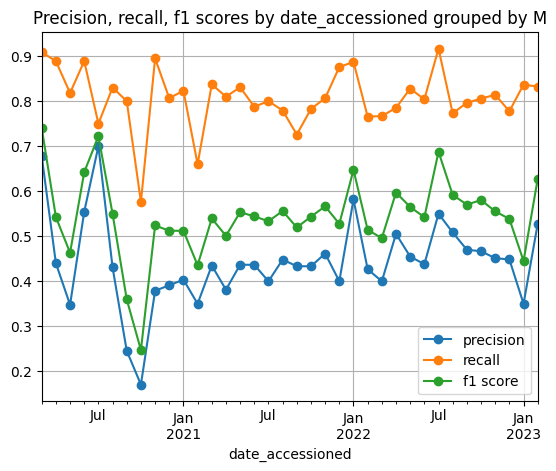

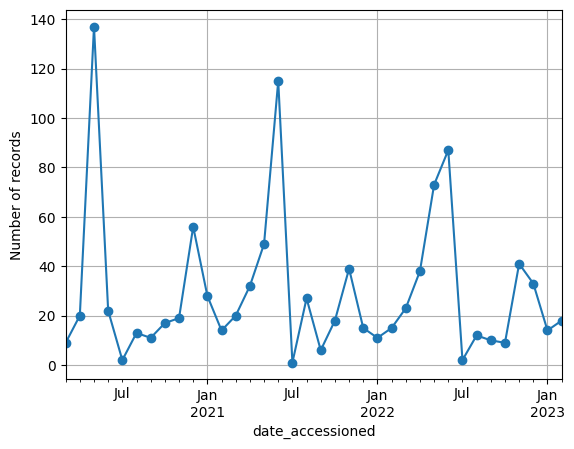

In [7]:
# date_isseued gives only the year, so we use date_accessioned
plot_scores(df_fi, "date_accessioned", groupby="M")

plt.figure()
# How many records there are each month?
df_fi.set_index('date_accessioned').resample("M").id.count().plot(marker='o')
plt.ylabel("Number of records")
plt.grid()

In [8]:
# Group by annif_update and give mean precision, recall, f1
df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count'])

/tmp/ipykernel_725030/3178142608.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count'])


precision          recall        f1 score      
                               mean count      mean count      mean count
annif_update                                                             
2020-12-01 00:00:00+00:00  0.396610   118  0.798265   118  0.507660   118
2021-04-01 00:00:00+00:00  0.430242   248  0.796228   248  0.540933   248
2021-11-01 00:00:00+00:00  0.459813   214  0.811845   214  0.561534   214
2022-06-01 00:00:00+00:00  0.451667   120  0.802214   120  0.554786   120
2022-11-01 00:00:00+00:00  0.450000   106  0.808728   106  0.547723   106

# Trepo
Annif integration to use in Trepo and Theseus in 7.9.2020

Note that the data set contains various document types, see below

In [9]:
with open("trepo.ndjson") as f:
    data = ndjson.load(f)
df = pd.DataFrame(data)

df.date_issued = pd.to_datetime(df.date_issued, errors='coerce', utc=True)
df.date_accessioned = pd.to_datetime(df.date_accessioned, errors='coerce', utc=True)
df['annif_update'] = df.date_accessioned.map(get_annif_update)

print(len(df))
print(len(df[df.language == 'fi']))
print(len(df[df.language == 'en']))
print(len(df[df.language == 'sv']))

68194
31729
26850
339


## Finnish

In [10]:
df_fi = df[df.language == 'fi']
df_fi = add_subjects_uris(df_fi, 'fi', source_col='subjects_all')
get_number_of_rows(df_fi)
# Retain only rows having both suggestions and subjects_uris
df_fi = retain_relevant(df_fi)
print()
df_fi.type.value_counts()

missing fi label 'väsyminen' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'FEM' found via ysa
missing fi label 'itsesäätely' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arvo' found via ysa
missing fi label 'arvo' found via ysa
missing fi label 'arvo' found via ysa
missing fi label 'terveystieto' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'fantasia' found via ysa
missing fi label 'kuormat' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'sijoitukset' found via ysa
missing fi label 'arvo' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'sopimuksellisuus' found via ysa
missing fi label 'itsesäätely' found via ysa
missing fi label 'itsesäätely' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'FEM' found via ysa
missing fi label 'arvot' found via ysa
missing fi label 'arv

/tmp/ipykernel_725030/839729998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_725030/839729998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


rows with subjects_all:  31086
rows with suggestions:  31729
rows with subjects_uris:  12321
rows with both suggestions & subject_uris:  5388



bachelorThesis    2647
masterThesis      2550
bookPart            63
doctoralThesis      57
report              40
book                19
workingPaper         5
                     3
article              2
review               1
other                1
Name: type, dtype: int64

/tmp/ipykernel_725030/839729998.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.resample(groupby).mean().plot(marker='o')


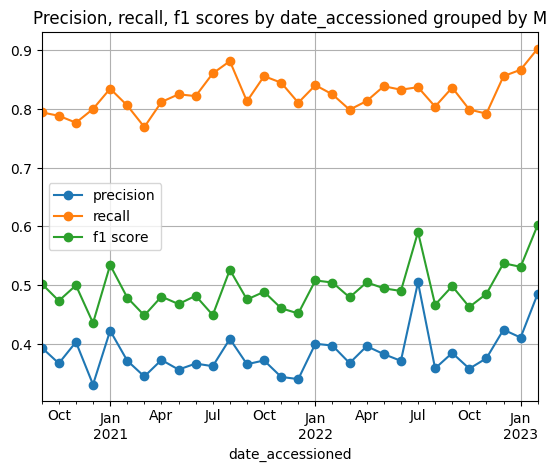

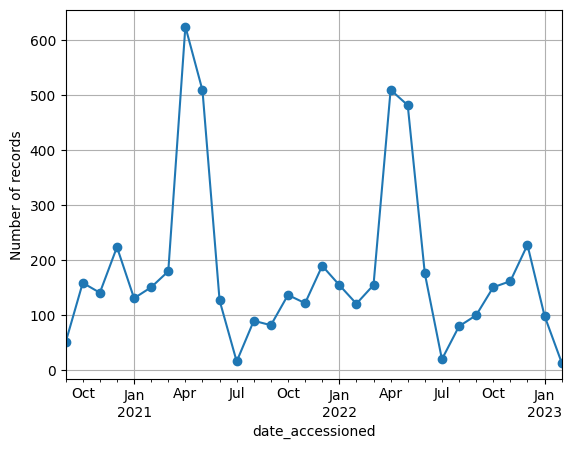

In [11]:
plot_scores(df_fi, "date_accessioned", groupby="M")

plt.figure()
# How many records there are with suggestions each month?
df_fi.set_index('date_accessioned').resample("M").id.count().plot(marker='o')
plt.ylabel("Number of records")
plt.grid()

In [12]:
# Group by annif_update and give mean precision, recall, f1
df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count'])

/tmp/ipykernel_725030/3178142608.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_fi.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count'])


precision          recall        f1 score      
                               mean count      mean count      mean count
annif_update                                                             
2020-12-01 00:00:00+00:00  0.361297   686  0.799339   686  0.467549   686
2021-04-01 00:00:00+00:00  0.368844  1586  0.824665  1586  0.479505  1586
2021-11-01 00:00:00+00:00  0.380807  1735  0.823745  1735  0.491228  1735
2022-06-01 00:00:00+00:00  0.373435   527  0.819072   527  0.484297   527
2022-11-01 00:00:00+00:00  0.407952   503  0.838187   503  0.521256   503

Text(0.5, 0.98, 'Trepo Finnish')

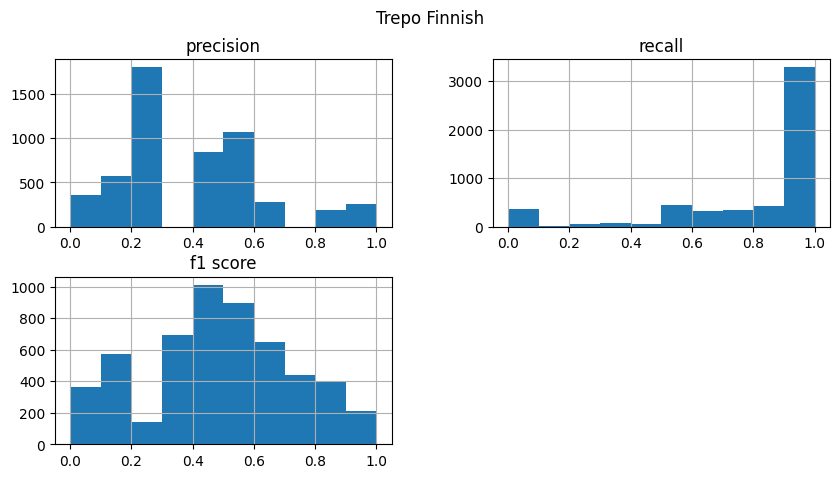

In [32]:
df_fi[['precision', 'recall', 'f1 score']].hist(bins=10, figsize=(10, 5))
plt.suptitle('Trepo Finnish')

The histogram of recall above indicates that nearly never users assigns subjects that
are not suggested by Annif. 

## English

In [34]:
df_lang = df[df.language == 'en']
df_lang = add_subjects_uris(df_lang, 'en', source_col='subjects_all')
get_number_of_rows(df_lang)
# Retain only rows having both suggestions and subjects_uris
df_lang = retain_relevant(df_lang)
print()
df_lang.type.value_counts()

Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
Error normalizing label 'None'
rows:  26850


/tmp/ipykernel_725030/839729998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df[source_col].apply(lambda x: [label_to_yso_uris(label, yso, lang, COMPLAIN) for label in x])
/tmp/ipykernel_725030/839729998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["subjects_uris"] = df["subjects_uris"].apply(lambda x: [str(item) for sublist in x for item in sublist])


rows with subjects_yso:  1334
rows with subjects_all:  25410
rows with suggestions:  26850
rows with subjects_uris:  4472
rows with both suggestions & subject_uris:  1415



masterThesis      1005
bachelorThesis     224
doctoralThesis     141
article             17
book                14
report               7
workingPaper         4
bookPart             2
other                1
Name: type, dtype: int64

/tmp/ipykernel_725030/839729998.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.resample(groupby).mean().plot(marker='o')


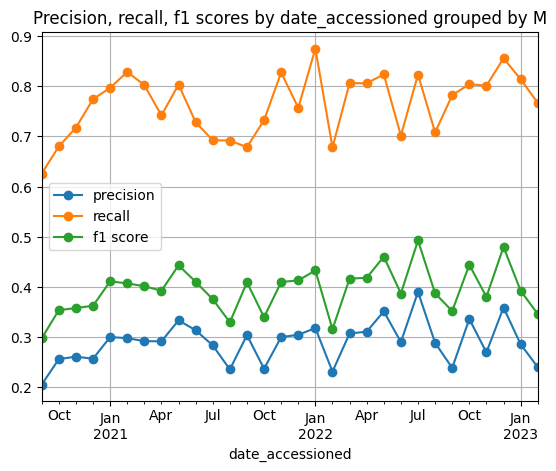

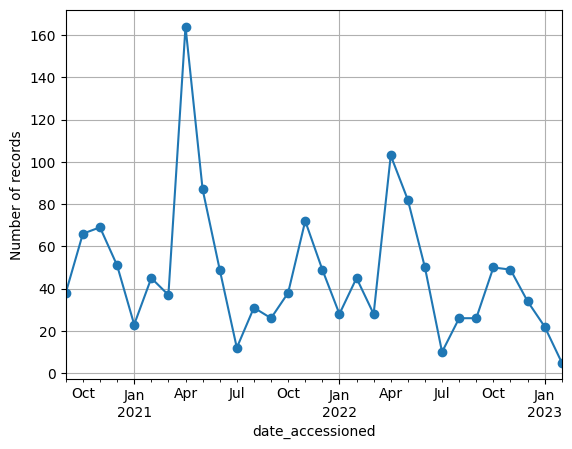

In [35]:
plot_scores(df_lang, "date_accessioned", groupby="M")

plt.figure()
# How many records there are with suggestions each month?
df_lang.set_index('date_accessioned')[df_lang.set_index('date_accessioned').suggestions.apply(lambda x: len(x) > 0)].resample("M").count().date_issued.plot(marker='o')
plt.ylabel("Number of records")
plt.grid()

In [36]:
df_lang.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count'])

/tmp/ipykernel_725030/3105915019.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_lang.groupby("annif_update")['precision', 'recall', 'f1 score'].agg(['mean', 'count'])


precision          recall        f1 score      
                               mean count      mean count      mean count
annif_update                                                             
2020-12-01 00:00:00+00:00  0.283333   156  0.799847   156  0.391681   156
2021-04-01 00:00:00+00:00  0.294267   407  0.743096   407  0.396136   407
2021-11-01 00:00:00+00:00  0.307671   407  0.797990   407  0.414024   407
2022-06-01 00:00:00+00:00  0.301852   162  0.754643   162  0.405440   162
2022-11-01 00:00:00+00:00  0.298961   110  0.818946   110  0.411787   110

Text(0.5, 0.98, 'Trepo English')

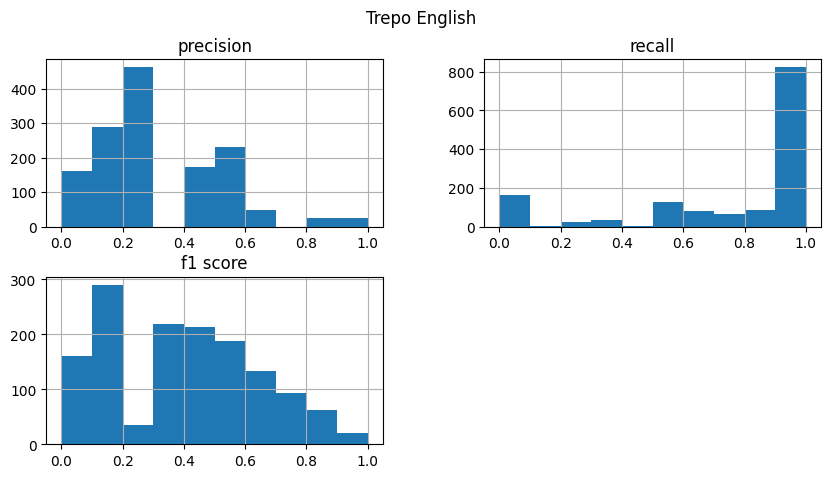

In [37]:
df_lang[['precision', 'recall', 'f1 score']].hist(bins=10, figsize=(10, 5))
plt.suptitle('Trepo English')